In [1]:
import pandas as pd
import numpy as np
from math import log
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
class Leaf:
    def __init__(self,ans,probability):
        self.next = None
        self.ans  = ans
        self.probability = probability
        
class Node:
    def __init__(self,question,values):
        d = dict()
        for value in values:
            d[value]=None
        self.next = d
        self.question = question

In [3]:
def Get_Table_with_only(data , col, value):
    to_remove = []
    for index, row in data.iterrows():
        if(row[col] != value):
            to_remove.append(index)
    Y = data.drop(to_remove)
    Y.drop(col, axis=1, inplace=True)
    Y = Y.reset_index(drop=True)
    return Y
def give_space(count):
    for i in range(count):
        print("\t",end="")
            
def prob(data):
    headers = data.columns.values
    Rows_count=data[headers[-1]].value_counts()        
    yes = 0
    no  = 0
    try:
        yes = Rows_count['yes']
    except:
        try:
            yes = Rows_count[1]
        except:
            pass
    try:
        no  = Rows_count['no']
    except:
        try:
            no = Rows_count[0]
        except:
            pass
    if(yes>=no):
        return "yes", yes/(yes+no)
    else:
        return "no", no/(yes+no)

In [4]:
def print_tree(Tree,count=0):
    if(Tree==None):
        print("\n",end="")
        return
    elif(Tree.next==None):
        print(" : ",end="")
        print(Tree.ans)
        return
    else:
        print("\n",end="")        
        for k in Tree.next:
            for i in range(count):
                print("\t",end="")
            print("| "+Tree.question+" = "+str(k),end="")
            print_tree(Tree.next[k],count+1)

def predict(tree_gini,test_data):
    L = []
    header = list(test_data.columns)
    header.append('Predicted')
    for i in range(len(test_data)):
        l=list(test_data.loc[i])
        l.append(predict_util(tree_gini, test_data, i))
        L.append(l)
    df = pd.DataFrame(L,columns=header)
    return df

def predict_util(Tree,data,row):
    if(Tree==None):
        return 'dont_know'
    elif(Tree.next==None):
        return Tree.ans
    else:
        return predict_util(Tree.next[data[Tree.question][row]], data, row)

In [5]:
def GINI(data):
    headers = data.columns.values
    L = data[headers[-1]].value_counts()
    gini = 1
    for i in range(len(L)):
        gini-=(L.iloc[i]/data.shape[0])**2
    return gini

def ENTROPY(data):
    headers = data.columns.values
    L = data[headers[-1]].value_counts()
    entropy = 0
    for i in range(len(L)):
        x = (L.iloc[i]/data.shape[0])
        entropy-=(x)*log(x,2)
    return entropy

In [6]:
def Get_Column_GINI(data):
    if(len(data) ==0):
        return "",[]
    G = GINI(data)
    headers = data.columns.values
    answer_g = 1000000
    answer_col =""
    for col in headers:
        if(headers[-1] != col):
            Rows_count=data[col].value_counts()
            temp = 0
            for value in Rows_count.index.values:
                query = str(col)+str('=="')+str(value)+str('"')
                try:
                    D = (data.query(query)).drop([str(col)], axis=1)
                except:
                    D = Get_Table_with_only(data,col,value)
                g = GINI(D)
                temp += (1.0*(g*D.shape[0])/data.shape[0])
            if ( temp<G and temp <= answer_g):
                answer_col = col
                answer_g = temp
    if(answer_col != ""):
        diff_values = list(data[answer_col].value_counts().index)
        return answer_col,diff_values
    else:
        return answer_col , []

In [7]:
def Get_Column_ENTROPY(data):
    if(len(data) ==0):
        return "",[]
    G = ENTROPY(data)
    headers = data.columns.values
    answer_g = 1000000
    answer_col =""
    for col in headers:
        if(headers[-1] != col):
            Rows_count=data[col].value_counts()
            temp = 0
            for value in Rows_count.index.values:    
                
                query = str(col)+str('=="')+str(value)+str('"')
                try:
                    D = data.query(query)
                except:
                    D = Get_Table_with_only(data,col,value)                
                g = ENTROPY(D)
                temp += (1.0*(g*D.shape[0])/data.shape[0])
            if ( temp<G and temp <= answer_g):
                answer_col = col
                answer_g = temp
    if(answer_col != ""):
        diff_values = list(data[answer_col].value_counts().index)
        return answer_col,diff_values
    else:
        return answer_col , []

In [8]:
def get_Best_node(Dataset):
    D = Dataset.values
    p1 = np.sum(D[:,-1])/D.shape[0]
    p2 = 1-p1
    E = 0
    if(p1!=0):
        E  -= p1*log(p1,2)
    if(p2!=0):
        E  -= p2*log(p2,2)
    ans = 1000000
    ans_col =""
    columns = Dataset.columns.values
    for col in range(len(columns)-1):
        A = D[:,col]
        B = D[:,-1]
        S = A.shape[0]
        A = A.reshape((S,1))
        B = B.reshape((S,1))
        NA = np.logical_not(A)
        NB = np.logical_not(B)
        OO = np.bitwise_and(A,B)
        OZ = np.bitwise_and(A, NB)
        ZO = np.bitwise_and(NA, B)
        ZZ = np.bitwise_and(NA, NB)
        OO = np.sum(OO)
        ZO = np.sum(ZO)
        OZ = np.sum(OZ)
        ZZ = np.sum(ZZ)
        assert(OO+OZ+ZO+ZZ == S)
        N1 = np.sum(A).reshape((1,1))
        NO = len(A)-N1
        tm  =0
        tm2 =0
        try:
            tm -= (OO/(OO+OZ))*log((OO/(OO+OZ)),2)
        except:
            pass
        try:
            tm -= (OZ/(OO+OZ))*log((OZ/(OO+OZ)),2) 
        except:
            pass
        try:
            tm2 -= (ZO/(ZO+ZZ))*log((ZO/(ZO+ZZ)),2)
        except:
            pass
        try:
            tm2 -=  (ZZ/(ZO+ZZ))*log((ZZ/(ZO+ZZ)),2)
        except:
            pass

        WE1 = (N1[0][0]/len(A))*tm
        WEO = (NO[0][0]/len(A))*tm2
        T  = (WEO+WE1)
        if( T <=ans and T < E):
            ans = T
            ans_col = columns[col]
    return ans_col

In [9]:
def Get_Info_gain_root_ENTROPY(data):
    G = ENTROPY(data)
    print('Entropy of Root:',G)
    headers = data.columns.values
    answer_g = 1000000
    answer_col =""
    for col in headers:
        if(headers[-1] != col):
            Rows_count=data[col].value_counts()
            temp = 0
            for value in Rows_count.index.values:    
                query = str(col)+str('=="')+str(value)+str('"')
                try:
                    D = data.query(query)
                except:
                    D = Get_Table_with_only(data,col,value)                
                g = ENTROPY(D)
                temp += (1.0*(g*D.shape[0])/data.shape[0])
            if ( temp<G and temp <= answer_g):
                answer_col = col
                answer_g = temp
    return G-answer_g

In [10]:
def Get_root_GINI_index(data):
    G = GINI(data)
    headers = data.columns.values
    answer_g = 1000000
    answer_col =""
    for col in headers:
        if(headers[-1] != col):
            Rows_count=data[col].value_counts()
            temp = 0
            for value in Rows_count.index.values:
                query = str(col)+str('=="')+str(value)+str('"')
                try:
                    D = (data.query(query)).drop([str(col)], axis=1)
                except:
                    D = Get_Table_with_only(data,col,value)
                g = GINI(D)
                temp += (1.0*(g*D.shape[0])/data.shape[0])
            if ( temp<G and temp <= answer_g):
                answer_col = col
                answer_g = temp
    return G, answer_g

In [11]:
def get_tree_GINI(data, height=None):
    if(height==None):
        if(len(data.columns.values)==1):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L
    else:
        if((len(data.columns.values)==1) or (height<=0)):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L
    name, values = Get_Column_GINI(data)
    if(len(values)==0):
        answer, probability = prob(data)
        L = Leaf(answer, probability)
        return L
    N = Node(name,values)
    for value in values:
        New_data = Get_Table_with_only(data, name,value) 
        if(height==None):
            New_node = get_tree_GINI(New_data)        
        else:
            New_node = get_tree_GINI(New_data, height-1)
        N.next[value] = New_node
    return N

def get_tree_ENTROPY(data, height=None):
    if(height==None):
        if(len(data.columns.values)==1):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L
    else:
        if((len(data.columns.values)==1) or (height<=0)):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L    
    
    name, values = Get_Column_ENTROPY(data)
    if(len(name)>0 and height is not None):
        print("HEIGHT:", height, "NAME:",name)
    if(len(values)==0):
        answer, probability = prob(data)
        L = Leaf(answer, probability)
        return L
    N = Node(name,values)
    
    for value in values:
        New_data = Get_Table_with_only(data, name,value)
        if(height==None):
            New_node = get_tree_ENTROPY(New_data)        
        else:
#             print(height)
            New_node = get_tree_ENTROPY(New_data, height-1)
        N.next[value] = New_node
    return N

## Training decision tree classifier on the train-data

In [12]:
data         = pd.read_csv('dataset for part 1 - Training Data.csv')
test_data    = pd.read_csv('dataset for part 1 - Test Data.csv')
tree_gini    = get_tree_GINI(data)
tree_entropy = get_tree_ENTROPY(data)

### Printing out the decision tree (Gini Index)

In [13]:
print_tree(tree_gini)


| maintenance = med
	| price = med
		| airbag = no : no
		| airbag = yes : yes
	| price = low : no
	| price = high : yes
| maintenance = high
	| capacity = 2 : no
	| capacity = 5 : yes
	| capacity = 4 : no
| maintenance = low : yes


### Printing out the decision tree (Information Gain)

In [14]:
print_tree(tree_entropy)


| maintenance = med
	| price = med
		| airbag = no : no
		| airbag = yes : yes
	| price = low : no
	| price = high : yes
| maintenance = high
	| capacity = 2 : no
	| capacity = 5 : yes
	| capacity = 4 : no
| maintenance = low : yes


### Value of Information Gain and Gini Index of the root node

In [15]:
root_g, split = Get_root_GINI_index(data)
print("Gini index of Root:\t", root_g, "\nGini(split) at Root:\t", split,"\n")

root_e = Get_Info_gain_root_ENTROPY(data)
print("Information Gain of root:", root_e)

Gini index of Root:	 0.49382716049382713 
Gini(split) at Root:	 0.38888888888888884 

Entropy of Root: 0.9910760598382222
Information Gain of root: 0.18606356007860758


### Prediction on Train-data (Gini Index)

In [16]:
predict(tree_gini, data)

,price,maintenance,capacity,airbag,profitable,Predicted
0,low,low,2,no,yes,yes
1,low,med,4,yes,no,no
2,low,high,4,no,no,no
3,med,med,4,no,no,no
4,med,med,4,yes,yes,yes
5,med,high,2,yes,no,no
6,high,med,4,yes,yes,yes
7,high,high,2,yes,no,no
8,high,high,5,yes,yes,yes


### Prediction on Test-data (Gini Index)

In [17]:
predict(tree_gini, test_data)

,price,maintenance,capacity,airbag,profitable,Predicted
0,med,high,5,no,yes,yes
1,low,low,4,no,yes,yes


### Prediction on Train-data (Information Gain)

In [18]:
predict(tree_entropy, data)

,price,maintenance,capacity,airbag,profitable,Predicted
0,low,low,2,no,yes,yes
1,low,med,4,yes,no,no
2,low,high,4,no,no,no
3,med,med,4,no,no,no
4,med,med,4,yes,yes,yes
5,med,high,2,yes,no,no
6,high,med,4,yes,yes,yes
7,high,high,2,yes,no,no
8,high,high,5,yes,yes,yes


### Prediction on Test-data (Information Gain)

In [19]:
predict(tree_entropy, test_data)

,price,maintenance,capacity,airbag,profitable,Predicted
0,med,high,5,no,yes,yes
1,low,low,4,no,yes,yes


### Converting Dataset to 0 and 1

In [20]:
data = pd.read_csv('dataset for part 1 - Training Data.csv')
testdata = pd.read_csv('dataset for part 1 - Test Data.csv')

data[data.columns[0]]  = data[data.columns[0]].astype(str)
data[data.columns[1]]  = data[data.columns[1]].astype(str)
data[data.columns[2]]  = data[data.columns[2]].astype(str)
data[data.columns[3]]  = data[data.columns[3]].map(dict(yes=1, no=0))
data[data.columns[4]]  = data[data.columns[4]].map(dict(yes=1, no=0))

testdata[testdata.columns[0]]  = testdata[testdata.columns[0]].astype(str)
testdata[testdata.columns[1]]  = testdata[testdata.columns[1]].astype(str)
testdata[testdata.columns[2]]  = testdata[testdata.columns[2]].astype(str)
testdata[testdata.columns[3]]  = testdata[testdata.columns[3]].map(dict(yes=1, no=0))
testdata[testdata.columns[4]]  = testdata[testdata.columns[4]].map(dict(yes=1, no=0))

Train = pd.get_dummies(data, prefix=['price','maintenance','capacity'])
Train = Train[['airbag', 'price_high', 'price_low', 'price_med', 'maintenance_high', 'maintenance_low', 'maintenance_med', 'capacity_2','capacity_4', 'capacity_5', 'profitable']]
Train = Train.applymap(int)

Test = pd.get_dummies(testdata, prefix=['price','maintenance','capacity'])
for col in Train.columns:
    try:
        Test[col]
    except:
        l = len(Test)
        Test[col] = [0]*l

Test = Test[['airbag', 'price_high', 'price_low', 'price_med', 'maintenance_high', 'maintenance_low', 'maintenance_med', 'capacity_2','capacity_4', 'capacity_5', 'profitable']]
Test = Test.applymap(int)

### Printing out the decision tree (Gini Index) (dummies used)

In [21]:
tree_gini_dummy = get_tree_GINI(Train)
print_tree(tree_gini_dummy)


| capacity_5 = 0
	| maintenance_high = 0
		| capacity_4 = 1
			| price_low = 0
				| airbag = 1 : yes
				| airbag = 0 : no
			| price_low = 1 : no
		| capacity_4 = 0 : yes
	| maintenance_high = 1 : no
| capacity_5 = 1 : yes


### Printing out the decision tree (Information Gain) (dummies used)

In [22]:
tree_entropy_dummy    = get_tree_ENTROPY(Train)
print_tree(tree_entropy_dummy)


| capacity_5 = 0
	| maintenance_high = 0
		| capacity_4 = 1
			| price_low = 0
				| airbag = 1 : yes
				| airbag = 0 : no
			| price_low = 1 : no
		| capacity_4 = 0 : yes
	| maintenance_high = 1 : no
| capacity_5 = 1 : yes


### Value of Information Gain and Gini Index of the root node (Dummies used)

In [23]:
root_g, split = Get_root_GINI_index(data)
print("Gini index of Root:\t", root_g, "\nGini(split) at Root:\t", split,"\n")

root_e = Get_Info_gain_root_ENTROPY(data)
print("Information Gain of root:", root_e)

Gini index of Root:	 0.49382716049382713 
Gini(split) at Root:	 0.38888888888888884 

Entropy of Root: 0.9910760598382222
Information Gain of root: 0.18606356007860758


### Prediction on Train-data (Gini Index) (dummies used)

In [24]:
predict(tree_gini_dummy, Train)

,airbag,price_high,price_low,price_med,maintenance_high,maintenance_low,maintenance_med,capacity_2,capacity_4,capacity_5,profitable,Predicted
0,0,0,1,0,0,1,0,1,0,0,1,yes
1,1,0,1,0,0,0,1,0,1,0,0,no
2,0,0,1,0,1,0,0,0,1,0,0,no
3,0,0,0,1,0,0,1,0,1,0,0,no
4,1,0,0,1,0,0,1,0,1,0,1,yes
5,1,0,0,1,1,0,0,1,0,0,0,no
6,1,1,0,0,0,0,1,0,1,0,1,yes
7,1,1,0,0,1,0,0,1,0,0,0,no
8,1,1,0,0,1,0,0,0,0,1,1,yes


### Prediction on Test-data (Gini Index) (dummies used)

In [25]:
predict(tree_gini_dummy, Test)

,airbag,price_high,price_low,price_med,maintenance_high,maintenance_low,maintenance_med,capacity_2,capacity_4,capacity_5,profitable,Predicted
0,0,0,0,1,1,0,0,0,0,1,1,yes
1,0,0,1,0,0,1,0,0,1,0,1,no


### Prediction on Train-data (Information Gain) (dummies used)

In [26]:
predict(tree_entropy_dummy, Train)

,airbag,price_high,price_low,price_med,maintenance_high,maintenance_low,maintenance_med,capacity_2,capacity_4,capacity_5,profitable,Predicted
0,0,0,1,0,0,1,0,1,0,0,1,yes
1,1,0,1,0,0,0,1,0,1,0,0,no
2,0,0,1,0,1,0,0,0,1,0,0,no
3,0,0,0,1,0,0,1,0,1,0,0,no
4,1,0,0,1,0,0,1,0,1,0,1,yes
5,1,0,0,1,1,0,0,1,0,0,0,no
6,1,1,0,0,0,0,1,0,1,0,1,yes
7,1,1,0,0,1,0,0,1,0,0,0,no
8,1,1,0,0,1,0,0,0,0,1,1,yes


### Prediction on Test-data (Information Gain) (dummies used)

In [27]:
predict(tree_entropy_dummy, Test)

,airbag,price_high,price_low,price_med,maintenance_high,maintenance_low,maintenance_med,capacity_2,capacity_4,capacity_5,profitable,Predicted
0,0,0,0,1,1,0,0,0,0,1,1,yes
1,0,0,1,0,0,1,0,0,1,0,1,no


## Scikit-Learn Decision Tree

### Training Models by Gini Index and Information Gain

In [28]:
# By Scikit-Learn Decision Tree
data    = pd.read_csv('dataset for part 1 - Training Data.csv')
Y_ML = data['profitable']
Y_ML = Y_ML.map(dict(yes=1, no=0))
X_ML = data.drop('profitable', axis=1)  

X_ML[X_ML.columns[0]]  = X_ML[X_ML.columns[0]].astype(str)
X_ML[X_ML.columns[1]]  = X_ML[X_ML.columns[1]].astype(str)
X_ML[X_ML.columns[2]]  = X_ML[X_ML.columns[2]].astype(str)
X_ML[X_ML.columns[3]]  = X_ML[X_ML.columns[3]].map(dict(yes=1, no=0))

Train_X = pd.get_dummies(X_ML, prefix=['price','maintenance','capacity'])
Train_X = Train_X.applymap(int)

MODEL = DecisionTreeClassifier(criterion='gini')  
MODEL = MODEL.fit(Train_X, Y_ML)  

Testdata= pd.read_csv('dataset for part 1 - Test Data.csv')
Test_Y  = Testdata['profitable']
Test_Y  = Test_Y.map(dict(yes=1, no=0))

Test_X  = Testdata.drop('profitable', axis=1)

Test_X[Test_X.columns[0]]  = Test_X[Test_X.columns[0]].astype(str)
Test_X[Test_X.columns[1]]  = Test_X[Test_X.columns[1]].astype(str)
Test_X[Test_X.columns[2]]  = Test_X[Test_X.columns[2]].astype(str)
Test_X[Test_X.columns[3]]  = Test_X[Test_X.columns[3]].map(dict(yes=1, no=0))

TestX_ML = pd.get_dummies(Test_X, prefix=['price','maintenance','capacity'])
for col in Train_X.columns:
    try:
        TestX_ML[col]
    except:
        l = len(TestX_ML)
        TestX_ML[col] = [0]*l
TestX_ML = TestX_ML[['airbag', 'price_high', 'price_low', 'price_med', 'maintenance_high', 'maintenance_low', 'maintenance_med', 'capacity_2','capacity_4', 'capacity_5']]
TestX_ML = TestX_ML.applymap(int)

MODEL2 = DecisionTreeClassifier(criterion="entropy")  
MODEL2 = MODEL2.fit(Train_X, Y_ML)  

### Prediction by Scikit Learn model on Train-Data

In [29]:
print("Training Labels:")
print('\t\t', np.array(Y_ML))
print("\n*********************Prediction on TRAIN DATA***********************")
print("\nModel Prediction on Train Data (Scikit-Learn) (Gini Index) (dummy)\n")
print("\t\t", MODEL.predict(Train_X))
print("\nModel Prediction on Train Data (Scikit-Learn) (Information Gain) (dummy)\n")
print("\t\t", MODEL2.predict(Train_X))

Training Labels:
		 [1 0 0 0 1 0 1 0 1]

*********************Prediction on TRAIN DATA***********************

Model Prediction on Train Data (Scikit-Learn) (Gini Index) (dummy)

		 [1 0 0 0 1 0 1 0 1]

Model Prediction on Train Data (Scikit-Learn) (Information Gain) (dummy)

		 [1 0 0 0 1 0 1 0 1]


### Prediction by Scikit Learn model on Test-Data

In [30]:
print("Testing Labels:")
print('\t\t', np.array(Test_Y))
print("\n*********************Prediction on TEST DATA***********************")
print("\nModel Prediction on Test Data (Scikit-Learn) (Gini Index) (dummy)\n")
print("\t\t", MODEL.predict(TestX_ML))
print("\nModel Prediction on Test Data (Scikit-Learn) (Information Gain) (dummy)\n")
print("\t\t", MODEL2.predict(TestX_ML))

Testing Labels:
		 [1 1]

*********************Prediction on TEST DATA***********************

Model Prediction on Test Data (Scikit-Learn) (Gini Index) (dummy)

		 [1 1]

Model Prediction on Test Data (Scikit-Learn) (Information Gain) (dummy)

		 [0 1]


### Visualization of the Decision Tree created by Scikit Learn (Gini Index)

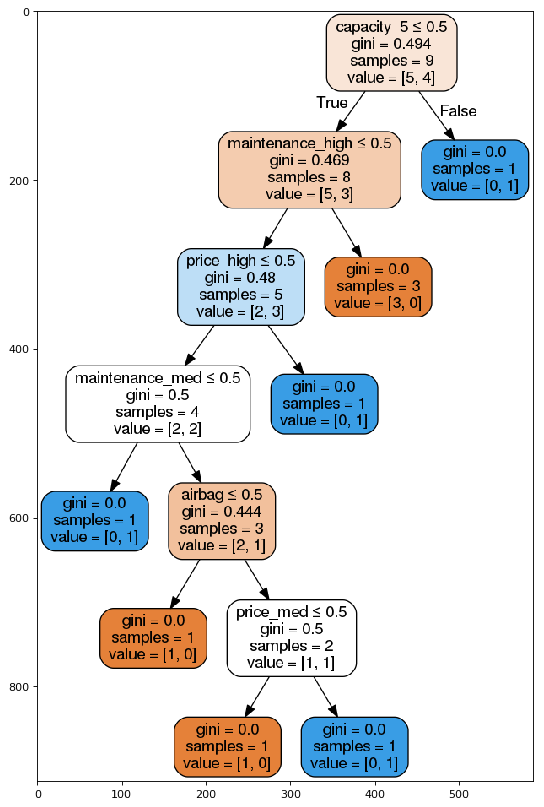

In [31]:
dotfile  = open("tree_ML_gini.dot",'w')
dot_data = tree.export_graphviz(MODEL, out_file=dotfile, filled = True, rounded= True, special_characters=True, feature_names=Train_X.columns)
dotfile.close()
os.system("dot -Tpng tree_ML_gini.dot > output_gini.png")
img      = mpimg.imread('output_gini.png')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
imgplot  = plt.imshow(img)
os.system("rm tree_ML_gini.dot")
plt.show()
plt.close()

### Visualization of the Decision Tree created by Scikit Learn (Information Gain)

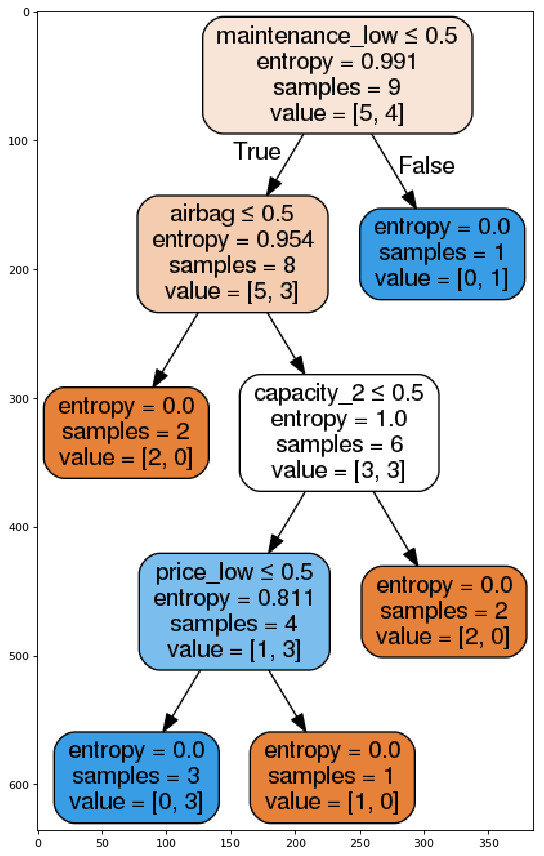

In [32]:
dotfile  = open("tree_ML_entropy.dot",'w')
dot_data = tree.export_graphviz(MODEL2, out_file=dotfile, filled = True, rounded= True, special_characters=True, feature_names=Train_X.columns)
dotfile.close()
os.system("dot -Tpng tree_ML_entropy.dot > output_entropy.png")
img      = mpimg.imread('output_entropy.png')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
imgplot  = plt.imshow(img)
os.system("rm tree_ML_entropy.dot")
plt.show()
plt.close()

# PartB

In [33]:
def get_Id_to_word(words):
    Id_to_Word = dict()
    for Id in range(1,len(words)+1):
        Id_to_Word[Id]=((words.iat[Id-1,0]).strip())
    return Id_to_Word

def get_docs_by_ids(traindata):
    docs = dict()
    for i in range(len(traindata)):
        ID = traindata.iat[i,0]
        V  = traindata.iat[i,1]
        if(ID in docs):
            docs[ID].add(V);
        else:
            docs[ID]=set()
            docs[ID].add(V)
    return docs
def get_docid_to_label(trainlabel):
    labels = dict()
    for Id in range(1,len(trainlabel)+1):
        labels[Id]=int(trainlabel.iat[Id-1,0])
    return labels

def create_dataset(WID_W, DID_WID, DID_L):
    col_len = len(WID_W)
    cols = []
    for w in WID_W:
        cols.append(WID_W[w])
    assert(len(cols)==col_len)
    Data = list()
    for DID in DID_WID:
        new_row = markone(DID_WID[DID],col_len)
        new_row.append(DID_L[DID]-1)
        Data.append(new_row)
    
    
    cols.append("Output")
    Data = pd.DataFrame(Data, columns=cols)
    return Data

def markone(S,col_len):
    A = [0]*col_len
    for i in S:
        A[i-1]=1
    return A

def GET_DATASET(path1, path2, wordid_to_word):
    traindata       = pd.read_csv(path1, sep='\t', header=None, keep_default_na=False)
    docid_to_wordid = get_docs_by_ids(traindata)

    trainlabel      = pd.read_csv(path2, sep='\t', header=None)
    docid_to_label  = get_docid_to_label(trainlabel)

    Dataset         = create_dataset(wordid_to_word, docid_to_wordid, docid_to_label)
    return Dataset

def Predict_on_SL_model(Dataset, model):
    ANS = model.predict(X)
    count = 0
    for i in range(len(Dataset)):
        if(Dataset.iat[i,-1]!=ANS[i]):
            count+=1
    print ("Number of misclassification:", count, "out of ", len(Dataset))
    return count,len(Dataset)

def accuracy(Real, Pred):
    assert(len(Real)==len(Pred))
    correct = 0
    incorrect = 0
    for i in range(len(Real)):
        if((Real[i]==0 and Pred[i]=='no')or(Real[i]==1 and Pred[i]=='yes')):
            correct+=1
        else:
            incorrect+=1
    assert((correct+incorrect) == len(Real))
    return (correct/len(Real))*100

def prediction_partB(TREE, Dataset, Test_Dataset):
    print("Predicting on Train Data (Information Gain)..")
    TrainPred  = predict(TREE, Dataset)
    TrainAccu  = accuracy(TrainPred['Output'],TrainPred['Predicted'])
    print('Training Accuracy :',TrainAccu,'%')

    print("Predicting on Test Data (Information Gain)..")
    TestPred   = predict(TREE, Test_Dataset)
    TestAccu   = accuracy(TestPred['Output'],TestPred['Predicted'])
    print('Training Accuracy :',TestAccu,'%')
    return [TrainAccu, TestAccu]

### Creating Dataset

In [34]:
words           = pd.read_csv('words.txt', header=None, keep_default_na=False) #prevent from reading null as NaN
wordid_to_word  = get_Id_to_word(words)

Dataset         = GET_DATASET('traindata.txt','trainlabel.txt',wordid_to_word)
Test_Dataset    = GET_DATASET('testdata.txt','testlabel.txt',wordid_to_word)

### By Scikit Learn

In [35]:
Y = Dataset['Output']
X = Dataset.drop('Output', axis=1)  
MODEL3 = DecisionTreeClassifier(criterion='entropy')  
MODEL3 = MODEL3.fit(X, Y)

print("On Train-Data:")
x,y = Predict_on_SL_model(Dataset, MODEL3)
print("Accuracy:",(y-x)*100/y,'%\n')
print("On Test-Data:")
x,y = Predict_on_SL_model(Test_Dataset, MODEL3)
print("Accuracy:",(y-x)*100/y,'%\n')

On Train-Data:
Number of misclassification: 0 out of  1060
Accuracy: 100.0 %

On Test-Data:
Number of misclassification: 162 out of  707
Accuracy: 77.08628005657708 %



### Visualization of the Decision Tree created by Scikit Learn (Information Gain)

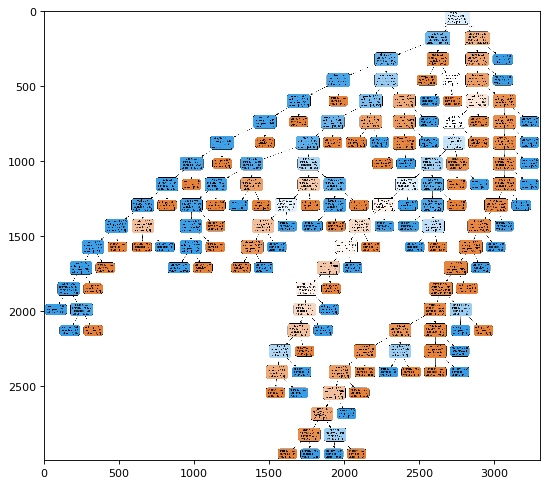

In [36]:
dotfile  = open("tree_ML_entropy_3.dot",'w')
dot_data = tree.export_graphviz(MODEL3, out_file=dotfile, filled = True, rounded= True, special_characters=True, feature_names=Dataset.columns[:-1])
dotfile.close()
os.system("dot -Tpng tree_ML_entropy_3.dot > output_entropy_3.png")
img      = mpimg.imread('output_entropy_3.png')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
os.system("rm tree_ML_entropy_3.dot")
imgplot  = plt.imshow(img)
plt.show()

### By My Model

In [37]:
def GET_TREE_ENTROPY(data, height=None):
    if(height==None):
        if(len(data.columns.values)==1):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L
    else:
        if((len(data.columns.values)==1) or (height<=0)):
            answer, probability = prob(data)
            L = Leaf(answer, probability)
            return L        
        
    name, values = GET_COL_ENTROPY(data)
    if(len(name)>0 and height is not None):
        print("HEIGHT:", height, "NAME:",name)
    if(len(values)==0):
        answer, probability = prob(data)
        L = Leaf(answer, probability)
        return L
    N = Node(name,values)
    
    for value in values:
        New_data = Get_Table_with_only(data, name,value)
        if(height==None):
            New_node = GET_TREE_ENTROPY(New_data)        
        else:
#             print(height)
            New_node = GET_TREE_ENTROPY(New_data, height-1)
        N.next[value] = New_node
    return N

def GET_COL_ENTROPY(data):
    if(len(data) ==0):
        return "",[]
    G = ENTROPY(data)
    headers = data.columns.values

    answer_g = 1000000
    answer_col =""
    answer_col = get_Best_node(data)
    if(answer_col != ""):
        diff_values = list(data[answer_col].value_counts().index)
        return answer_col,diff_values
    else:
        return answer_col , []


In [38]:
Results = []
Trees = dict()
for height in range(1,25):
    print('When Maximum Height:',height)
    print('Training Decision Tree...')
    TREE = GET_TREE_ENTROPY(Dataset,height)
    Trees[height] = TREE
    Res  = prediction_partB(TREE, Dataset, Test_Dataset)
    Res.append(height)
    print(Res)
    Results.append(Res)
    print('\n\n')

When Maximum Height: 1
Training Decision Tree...
HEIGHT: 1 NAME: writes


/home/vaibhav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/home/vaibhav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


Predicting on Train Data (Information Gain)..
Training Accuracy : 76.79245283018868 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 73.83309759547383 %
[76.79245283018868, 73.83309759547383, 1]



When Maximum Height: 2
Training Decision Tree...
HEIGHT: 2 NAME: writes
HEIGHT: 1 NAME: god
HEIGHT: 1 NAME: graphics
Predicting on Train Data (Information Gain)..
Training Accuracy : 82.0754716981132 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 81.47100424328147 %
[82.0754716981132, 81.47100424328147, 2]



When Maximum Height: 3
Training Decision Tree...
HEIGHT: 3 NAME: writes
HEIGHT: 2 NAME: god
HEIGHT: 1 NAME: that
HEIGHT: 1 NAME: use
HEIGHT: 2 NAME: graphics
HEIGHT: 1 NAME: image
Predicting on Train Data (Information Gain)..
Training Accuracy : 83.67924528301887 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 80.9052333804809 %
[83.67924528301887, 80.9052333804809, 3]



When Maximum Height: 4
Training Decision Tree...
HEIGHT: 4 

/home/vaibhav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
/home/vaibhav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in long_scalars


HEIGHT: 1 NAME: will
HEIGHT: 3 NAME: graphics
HEIGHT: 2 NAME: image
HEIGHT: 1 NAME: that
Predicting on Train Data (Information Gain)..
Training Accuracy : 85.66037735849056 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 84.01697312588402 %
[85.66037735849056, 84.01697312588402, 4]



When Maximum Height: 5
Training Decision Tree...
HEIGHT: 5 NAME: writes
HEIGHT: 4 NAME: god
HEIGHT: 3 NAME: that
HEIGHT: 2 NAME: bible
HEIGHT: 1 NAME: bill
HEIGHT: 2 NAME: wrote
HEIGHT: 1 NAME: people
HEIGHT: 1 NAME: came
HEIGHT: 3 NAME: use
HEIGHT: 2 NAME: will
HEIGHT: 4 NAME: graphics
HEIGHT: 3 NAME: image
HEIGHT: 2 NAME: that
HEIGHT: 1 NAME: program
HEIGHT: 1 NAME: keith
Predicting on Train Data (Information Gain)..
Training Accuracy : 87.83018867924528 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 82.17821782178217 %
[87.83018867924528, 82.17821782178217, 5]



When Maximum Height: 6
Training Decision Tree...
HEIGHT: 6 NAME: writes
HEIGHT: 5 NAME: god
HEIGHT: 4 

HEIGHT: 5 NAME: he
HEIGHT: 4 NAME: face
HEIGHT: 3 NAME: tammy
HEIGHT: 2 NAME: claiming
HEIGHT: 1 NAME: doubt
HEIGHT: 4 NAME: graphic
HEIGHT: 5 NAME: can
HEIGHT: 4 NAME: dwyer
HEIGHT: 3 NAME: coming
HEIGHT: 4 NAME: how
HEIGHT: 3 NAME: know
HEIGHT: 2 NAME: will
HEIGHT: 1 NAME: port
HEIGHT: 7 NAME: windows
HEIGHT: 8 NAME: came
HEIGHT: 7 NAME: ve
HEIGHT: 6 NAME: online
HEIGHT: 10 NAME: use
HEIGHT: 9 NAME: will
HEIGHT: 11 NAME: graphics
HEIGHT: 10 NAME: image
HEIGHT: 9 NAME: that
HEIGHT: 8 NAME: program
HEIGHT: 7 NAME: comp
HEIGHT: 6 NAME: csd
HEIGHT: 5 NAME: slow
HEIGHT: 4 NAME: uchicago
HEIGHT: 3 NAME: acm
HEIGHT: 2 NAME: tiff
HEIGHT: 1 NAME: algorithm
HEIGHT: 8 NAME: keith
HEIGHT: 7 NAME: god
HEIGHT: 6 NAME: who
HEIGHT: 5 NAME: have
HEIGHT: 4 NAME: am
HEIGHT: 3 NAME: time
HEIGHT: 2 NAME: by
HEIGHT: 1 NAME: with
HEIGHT: 4 NAME: rosenau
HEIGHT: 3 NAME: your
HEIGHT: 2 NAME: or
HEIGHT: 5 NAME: disk
Predicting on Train Data (Information Gain)..
Training Accuracy : 97.83018867924528 %
Predicti

HEIGHT: 6 NAME: or
HEIGHT: 9 NAME: disk
Predicting on Train Data (Information Gain)..
Training Accuracy : 99.24528301886792 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 82.74398868458275 %
[99.24528301886792, 82.74398868458275, 16]



When Maximum Height: 17
Training Decision Tree...
HEIGHT: 17 NAME: writes
HEIGHT: 16 NAME: god
HEIGHT: 15 NAME: that
HEIGHT: 14 NAME: bible
HEIGHT: 13 NAME: bill
HEIGHT: 12 NAME: if
HEIGHT: 11 NAME: book
HEIGHT: 10 NAME: cheers
HEIGHT: 9 NAME: snm
HEIGHT: 8 NAME: sole
HEIGHT: 10 NAME: to
HEIGHT: 11 NAME: thanks
HEIGHT: 10 NAME: you
HEIGHT: 9 NAME: tao
HEIGHT: 8 NAME: addition
HEIGHT: 9 NAME: there
HEIGHT: 8 NAME: time
HEIGHT: 7 NAME: your
HEIGHT: 6 NAME: for
HEIGHT: 5 NAME: circle
HEIGHT: 4 NAME: mp
HEIGHT: 14 NAME: wrote
HEIGHT: 13 NAME: people
HEIGHT: 12 NAME: religious
HEIGHT: 11 NAME: an
HEIGHT: 10 NAME: he
HEIGHT: 9 NAME: face
HEIGHT: 8 NAME: tammy
HEIGHT: 7 NAME: claiming
HEIGHT: 6 NAME: doubt
HEIGHT: 9 NAME: graphic
HEIGHT: 10

HEIGHT: 3 NAME: password
HEIGHT: 12 NAME: rosenau
HEIGHT: 11 NAME: your
HEIGHT: 10 NAME: or
HEIGHT: 13 NAME: disk
Predicting on Train Data (Information Gain)..
Training Accuracy : 99.81132075471699 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 82.74398868458275 %
[99.81132075471699, 82.74398868458275, 20]



When Maximum Height: 21
Training Decision Tree...
HEIGHT: 21 NAME: writes
HEIGHT: 20 NAME: god
HEIGHT: 19 NAME: that
HEIGHT: 18 NAME: bible
HEIGHT: 17 NAME: bill
HEIGHT: 16 NAME: if
HEIGHT: 15 NAME: book
HEIGHT: 14 NAME: cheers
HEIGHT: 13 NAME: snm
HEIGHT: 12 NAME: sole
HEIGHT: 14 NAME: to
HEIGHT: 15 NAME: thanks
HEIGHT: 14 NAME: you
HEIGHT: 13 NAME: tao
HEIGHT: 12 NAME: addition
HEIGHT: 13 NAME: there
HEIGHT: 12 NAME: time
HEIGHT: 11 NAME: your
HEIGHT: 10 NAME: for
HEIGHT: 9 NAME: circle
HEIGHT: 8 NAME: mp
HEIGHT: 18 NAME: wrote
HEIGHT: 17 NAME: people
HEIGHT: 16 NAME: religious
HEIGHT: 15 NAME: an
HEIGHT: 14 NAME: he
HEIGHT: 13 NAME: face
HEIGHT: 12 NAME: tam

HEIGHT: 4 NAME: atheists
HEIGHT: 10 NAME: just
HEIGHT: 9 NAME: tracing
HEIGHT: 9 NAME: says
HEIGHT: 20 NAME: keith
HEIGHT: 19 NAME: god
HEIGHT: 18 NAME: who
HEIGHT: 17 NAME: have
HEIGHT: 16 NAME: am
HEIGHT: 15 NAME: time
HEIGHT: 14 NAME: by
HEIGHT: 13 NAME: with
HEIGHT: 12 NAME: you
HEIGHT: 11 NAME: july
HEIGHT: 10 NAME: mac
HEIGHT: 9 NAME: au
HEIGHT: 8 NAME: get
HEIGHT: 7 NAME: password
HEIGHT: 16 NAME: rosenau
HEIGHT: 15 NAME: your
HEIGHT: 14 NAME: or
HEIGHT: 17 NAME: disk
Predicting on Train Data (Information Gain)..
Training Accuracy : 100.0 %
Predicting on Test Data (Information Gain)..
Training Accuracy : 82.74398868458275 %
[100.0, 82.74398868458275, 24]





### Train Accuracy and Test Accuracy VS Maximum Tree Depth

In [39]:
TR_Res = []
TE_Res = []
Depth  = []
counter = 1
for r in Results:
    TR_Res.append(r[0])
    TE_Res.append(r[1])
    Depth.append(r[2])
    assert(counter==r[2])
    counter+=1
Acc_Df = pd.DataFrame()
Acc_Df['Max_Depth']=pd.Series(Depth)
Acc_Df['Train_Accuracy']=pd.Series(TR_Res)
Acc_Df['Test_Accuracy']=pd.Series(TE_Res)
Acc_Df

,Max_Depth,Train_Accuracy,Test_Accuracy
0,1,76.792453,73.833098
1,2,82.075472,81.471004
2,3,83.679245,80.905233
3,4,85.660377,84.016973
4,5,87.830189,82.178218
5,6,90.566038,83.309760
6,7,91.698113,83.309760
7,8,93.113208,81.612447
8,9,94.528302,84.016973
9,10,96.037736,82.178218


### Plot of Train Accuracy and Test Accuracy VS Maximum Tree Depth

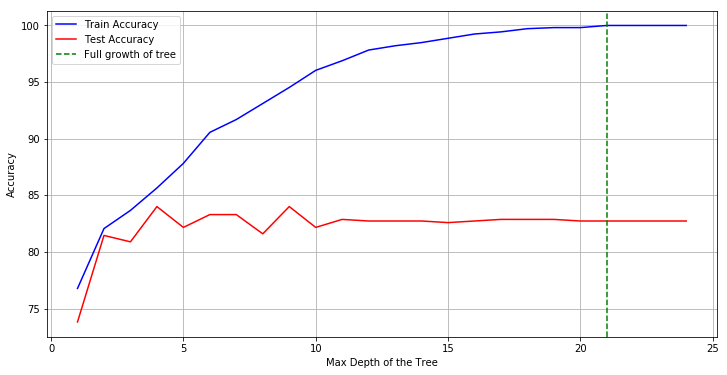

In [40]:
TR_Res = np.array(TR_Res)
TE_Res = np.array(TE_Res)
Depth  = np.array(Depth)

fig = plt.figure(figsize=(12, 6))
plt.plot(Depth, TR_Res, color='b', linestyle='-', label='Train Accuracy')
plt.plot(Depth, TE_Res, color='r', linestyle='-', label='Test Accuracy')
plt.axvline(x=21, color='g', linestyle='--',label='Full growth of tree')

plt.xlabel('Max Depth of the Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('PartB_Accuracy.png')
plt.grid()
plt.show()
plt.close()

### Printing Full Grown Tree

In [41]:
print_tree(Trees[24])


| writes = 0
	| god = 0
		| that = 0
			| bible = 0
				| bill = 0
					| if = 0
						| book = 0
							| cheers = 0
								| snm = 0
									| sole = 0 : yes
									| sole = 1 : no
								| snm = 1 : no
							| cheers = 1 : no
						| book = 1
							| to = 1 : yes
							| to = 0 : no
					| if = 1
						| thanks = 0
							| you = 0
								| tao = 0
									| addition = 0 : yes
									| addition = 1 : no
								| tao = 1 : no
							| you = 1
								| there = 0
									| time = 0
										| your = 0
											| for = 1 : yes
											| for = 0
												| circle = 0
													| mp = 0 : no
													| mp = 1 : yes
												| circle = 1 : yes
										| your = 1 : no
									| time = 1 : no
								| there = 1 : yes
						| thanks = 1 : yes
				| bill = 1 : no
			| bible = 1 : no
		| that = 1
			| wrote = 0
				| people = 0
					| religious = 0
						| an = 0
							| he = 0
								| face = 0
									| tammy = 0
										| claiming = 0
											| 

### Maximum Accuracy Tree

In [42]:
print_tree(Trees[9])


| writes = 0
	| god = 0
		| that = 0
			| bible = 0
				| bill = 0
					| if = 0
						| book = 0
							| cheers = 0
								| snm = 0 : yes
								| snm = 1 : no
							| cheers = 1 : no
						| book = 1
							| to = 1 : yes
							| to = 0 : no
					| if = 1
						| thanks = 0
							| you = 0
								| tao = 0 : yes
								| tao = 1 : no
							| you = 1
								| there = 0 : yes
								| there = 1 : yes
						| thanks = 1 : yes
				| bill = 1 : no
			| bible = 1 : no
		| that = 1
			| wrote = 0
				| people = 0
					| religious = 0
						| an = 0
							| he = 0
								| face = 0 : yes
								| face = 1 : no
							| he = 1
								| graphic = 0 : no
								| graphic = 1 : yes
						| an = 1
							| can = 1
								| dwyer = 0 : yes
								| dwyer = 1 : no
							| can = 0
								| how = 0 : yes
								| how = 1 : no
					| religious = 1 : no
				| people = 1
					| windows = 0 : no
					| windows = 1 : yes
			| wrote = 1
				| came = 0
					| ve = 0
						| online = 0